# Channel Map File Creation

In [1]:
# See the channel maps for Wifi and Router to undesrtand the 
# patterns described in this code to create the channel map (specifically for xc and yc).
# Also look https://microprobes.com/products/multichannel-arrays/fma to see
# the physical layout of the FMA and the numbers chosen.

# --- Unified FMA-Based Channel Map Generation System ---
import numpy as np
import matplotlib.pyplot as plt
import json

# Basic FMA parameters based on Microprobes specifications
# Each FMA has up to 36 electrode positions, but we use 32 recording channels
FMA_CHANNELS_PER_SHANK = 32
DEFAULT_XC_CENTER = 12.5  # micron
DEFAULT_YC_CENTER = 12.5  # micron
DEFAULT_X_STEP = 400      # micron - electrode spacing
DEFAULT_Y_STEP = 346.4    # micron - electrode spacing

# Default spacing between FMA arrays when implanted
DEFAULT_SHANK_H_SPACING = 4000  # micron
DEFAULT_SHANK_V_SPACING = 2000  # micron

# Generate standard channel mapping pattern
base_pattern = np.arange(0, 128, 4)
STANDARD_CHANNEL_MAP_PATTERN = np.concatenate([base_pattern + i for i in range(4)])


In [7]:
class FMAShank:
    """
    Class representing a single FMA (Floating Microelectrode Array).
    Based on Microprobes FMA specifications with 32 recording channels per array.
    """
    
    def __init__(self, shank_id, channels, xc, yc, k_coord):
        self.shank_id = shank_id
        self.channels = np.array(channels)
        self.xc = np.array(xc)
        self.yc = np.array(yc)
        self.k_coord = k_coord
        
    def to_dict(self):
        """Convert FMA shank to kilosort-compatible dictionary format."""
        return {
            'chanMap': self.channels,
            'xc': self.xc,
            'yc': self.yc,
            'kcoords': np.full(len(self.channels), self.k_coord, dtype=int)
        }
    
    def get_center(self):
        """Get the center coordinates of the FMA array."""
        return np.mean(self.xc), np.mean(self.yc)
    
    def apply_transformation(self, rotation_angle=0, flip_x=False, flip_y=False, 
                           additional_rotation=0):
        """
        Apply transformations to the FMA electrode coordinates.
        
        Parameters:
        - rotation_angle: primary rotation in radians
        - flip_x: whether to flip x coordinates
        - flip_y: whether to flip y coordinates  
        - additional_rotation: additional rotation in radians (applied after primary)
        """
        xc, yc = self.xc.copy(), self.yc.copy()
        
        # Apply coordinate flipping first
        if flip_x:
            xc = np.flip(xc)
        if flip_y:
            yc = np.flip(yc)
        
        # Apply primary rotation
        if rotation_angle != 0:
            center_x, center_y = np.mean(xc), np.mean(yc)
            cos_a, sin_a = np.cos(rotation_angle), np.sin(rotation_angle)
            xc_centered = xc - center_x
            yc_centered = yc - center_y
            xc_rotated = xc_centered * cos_a - yc_centered * sin_a
            yc_rotated = xc_centered * sin_a + yc_centered * cos_a
            xc = xc_rotated + center_x
            yc = yc_rotated + center_y
        
        # Apply additional rotation
        if additional_rotation != 0:
            center_x, center_y = np.mean(xc), np.mean(yc)
            cos_a, sin_a = np.cos(additional_rotation), np.sin(additional_rotation)
            xc_centered = xc - center_x
            yc_centered = yc - center_y
            xc_rotated = xc_centered * cos_a - yc_centered * sin_a
            yc_rotated = xc_centered * sin_a + yc_centered * cos_a
            xc = xc_rotated + center_x
            yc = yc_rotated + center_y
        
        self.xc = xc
        self.yc = yc

def create_fma_shank(shank_id, channel_range, base_position=(0, 0), 
                     k_coord_value=1, electrode_params=None, transformations=None):
    """
    Create a single FMA shank with specified parameters.
    
    Parameters:
    - shank_id: unique identifier for this FMA
    - channel_range: tuple (min_channel, max_channel) or list of channel indices
    - base_position: tuple (x_offset, y_offset) for FMA positioning in cortex
    - k_coord_value: value to assign to k_coords for this shank
    - electrode_params: dict with electrode layout parameters or None for defaults
    - transformations: dict with transformation parameters or None for defaults
    
    Returns:
    - FMAShank object
    """
    
    # Handle channel range input
    if isinstance(channel_range, tuple) and len(channel_range) == 2:
        min_ch, max_ch = channel_range
        channels = list(range(min_ch, max_ch + 1))
    elif isinstance(channel_range, list):
        channels = channel_range
    else:
        raise ValueError("channel_range must be tuple (min, max) or list of channels")
    
    if len(channels) != FMA_CHANNELS_PER_SHANK:
        raise ValueError(f"Each FMA must have exactly {FMA_CHANNELS_PER_SHANK} channels, got {len(channels)}")
    
    # Set electrode parameters (use defaults if not provided)
    if electrode_params is None:
        electrode_params = {}
    
    xc_center = electrode_params.get('xc_center', DEFAULT_XC_CENTER)
    yc_center = electrode_params.get('yc_center', DEFAULT_YC_CENTER)
    x_step = electrode_params.get('x_step', DEFAULT_X_STEP)
    y_step = electrode_params.get('y_step', DEFAULT_Y_STEP)
    
    # Generate FMA electrode pattern (based on Microprobes layout)
    # 4 rows of 8 electrodes each, with alternating row offset pattern
    base_patternB = np.flip(np.arange(xc_center + x_step/2, xc_center + x_step * 8 + x_step/2, x_step))  # Rows 2,4: offset
    base_patternA = np.flip(np.arange(xc_center, x_step * 8, x_step))  # Rows 1,3: standard
    
    xc_template = np.concatenate([base_patternA if i%2==0 else base_patternB for i in range(4)])
    yc_template = np.concatenate([np.array([yc_center] * 8) + y_step * i for i in range(4)])
    
    # Create FMA shank object
    shank = FMAShank(shank_id, channels, xc_template.copy(), yc_template.copy(), k_coord_value)
    
    # Apply transformations if specified
    if transformations is not None:
        shank.apply_transformation(
            rotation_angle=transformations.get('rotation_angle', 0),
            flip_x=transformations.get('flip_x', False),
            flip_y=transformations.get('flip_y', False),
            additional_rotation=transformations.get('additional_rotation', 0)
        )
    
    # Apply base position offset
    base_x, base_y = base_position
    shank.xc += base_x
    shank.yc += base_y
    
    return shank

def create_multichannel_probe(config_name, shank_positions, active_shanks, 
                            channel_map_pattern, transformations=None, 
                            electrode_params=None, total_channels=128):
    """
    Create a complete multi-channel probe configuration using multiple FMA arrays.
    
    Parameters:
    - config_name: name for this configuration
    - shank_positions: dict mapping shank_id to (x, y) position coordinates
    - active_shanks: list of shank IDs to include in configuration
    - channel_map_pattern: array defining channel mapping across shanks
    - transformations: dict mapping shank_id to transformation parameters
    - electrode_params: dict with electrode layout parameters
    - total_channels: total number of channels (default 128)
    
    Returns:
    - Complete probe dictionary compatible with kilosort
    """
    
    # if len(active_shanks) * FMA_CHANNELS_PER_SHANK != total_channels:
    #     raise ValueError(f"Active shanks ({len(active_shanks)}) * channels per shank ({FMA_CHANNELS_PER_SHANK}) must equal total channels ({total_channels})")
    
    if transformations is None:
        transformations = {}
    
    # Create all FMA shanks
    shanks = []
    
    for idx, shank_id in enumerate(active_shanks):
        # Validate shank position
        if shank_id not in shank_positions:
            raise ValueError(f"Position not defined for shank {shank_id}")
        
        # Calculate channel range for this shank
        start_ch = idx * FMA_CHANNELS_PER_SHANK
        end_ch = start_ch + FMA_CHANNELS_PER_SHANK
        shank_channels = channel_map_pattern[start_ch:end_ch]
        
        # Get transformation parameters for this shank
        shank_transforms = transformations.get(shank_id, {})
        
        # Create the FMA shank
        shank = create_fma_shank(
            shank_id=shank_id,
            channel_range=list(shank_channels),
            base_position=shank_positions[shank_id],
            k_coord_value=idx + 1,  # k_coords numbered 1-4 in channel map
            electrode_params=electrode_params,
            transformations=shank_transforms
        )
        
        shanks.append(shank)
    
    # Combine all shanks into probe dictionary
    chanMap_combined = []
    xc_combined = []
    yc_combined = []
    kcoords_combined = []
    
    for shank in shanks:
        shank_dict = shank.to_dict()
        chanMap_combined.extend(shank_dict['chanMap'])
        xc_combined.extend(shank_dict['xc'])
        yc_combined.extend(shank_dict['yc'])
        kcoords_combined.extend(shank_dict['kcoords'])
    
    return {
        'chanMap': chanMap_combined,
        'xc': xc_combined,
        'yc': yc_combined,
        'kcoords': kcoords_combined,
        'n_chan': total_channels,
        'config_name': config_name,
        'active_shanks': active_shanks,
        'shank_positions': shank_positions
    }


In [ ]:
# --- Predefined Configurations ---

def create_wifi_configuration(config_name="wifi_standard"):
    """
    Create standard Wifi configuration using 4 FMA arrays.
    
    Layout:
    [ D ]  [ C ]     where [A, B, C, D] = [1, 2, 3, 4]
    [ B ]  [ A ]
    """
    
    # Define positions for 4 FMA arrays
    wifi_positions = {
        1: (0, 0),                                              # A: Bottom-right
        2: (-DEFAULT_SHANK_H_SPACING, 0),                       # B: Bottom-left  
        3: (0, DEFAULT_SHANK_V_SPACING),                        # C: Top-right
        4: (-DEFAULT_SHANK_H_SPACING, DEFAULT_SHANK_V_SPACING)  # D: Top-left
    }
    
    # Define transformations (shanks C and D need coordinate flipping)
    wifi_transformations = {
        1: {},  # No transformation
        2: {},  # No transformation
        3: {'flip_x': True, 'flip_y': True},  # Flip coordinates
        4: {'flip_x': True, 'flip_y': True}   # Flip coordinates
    }
    
    active_shanks = [1, 2, 3, 4]
    
    return create_multichannel_probe(
        config_name=config_name,
        shank_positions=wifi_positions,
        active_shanks=active_shanks,
        channel_map_pattern=STANDARD_CHANNEL_MAP_PATTERN,
        transformations=wifi_transformations
    ), wifi_positions, wifi_transformations

def create_router_configuration(active_shanks, config_name="router_config"):
    """
    Create Router configuration using specified FMA arrays from 6 available positions.
    
    Layout:
        4    5
       3
     2      6
    1
    """
    
    if len(active_shanks) != 4:
        raise ValueError("Router configuration requires exactly 4 active shanks")
    
    # Define all 6 possible positions for Router FMA arrays
    router_positions = {
    1: (0, 0),
    2: (DEFAULT_SHANK_H_SPACING/6., DEFAULT_SHANK_V_SPACING),
    3: (DEFAULT_SHANK_H_SPACING/4., 2 * DEFAULT_SHANK_V_SPACING),
    4: (DEFAULT_SHANK_H_SPACING/3., 3 * DEFAULT_SHANK_V_SPACING),
    5: (1.0 * DEFAULT_SHANK_H_SPACING, 2.1 * DEFAULT_SHANK_V_SPACING),
    6: (0.8 * DEFAULT_SHANK_H_SPACING, 0.3 * DEFAULT_SHANK_V_SPACING)
    }
    
    # Define transformations (shanks 5 and 6 need 90° rotation)
    router_transformations = {
        1: {},  # No transformation
        2: {},  # No transformation
        3: {},  # No transformation
        4: {},  # No transformation
        5: {'rotation_angle': np.pi/2, 'flip_x': True, 'flip_y': True},  # 90° rotation and flip
        6: {'rotation_angle': np.pi/2, 'additional_rotation': np.radians(-20), 'flip_x': True, 'flip_y': True}  # 90° + additional slant and flip
    }
    
    # Extract positions for active shanks
    active_positions = {shank_id: router_positions[shank_id] for shank_id in active_shanks}
    active_transformations = {shank_id: router_transformations.get(shank_id, {}) for shank_id in active_shanks}
    
    return create_multichannel_probe(
        config_name=config_name,
        shank_positions=active_positions,
        active_shanks=active_shanks,
        channel_map_pattern=STANDARD_CHANNEL_MAP_PATTERN,
        transformations=active_transformations
    ), router_positions, router_transformations

def create_custom_configuration(config_name, shank_positions, active_shanks, 
                              transformations=None, electrode_params=None):
    """
    Create a custom FMA configuration with arbitrary positions and transformations.
    
    Parameters:
    - config_name: name for the configuration
    - shank_positions: dict mapping shank_id to (x, y) coordinates
    - active_shanks: list of shank IDs to include
    - transformations: dict mapping shank_id to transformation parameters
    - electrode_params: custom electrode parameters
    
    Returns:
    - Complete probe configuration
    """
    
    return create_multichannel_probe(
        config_name=config_name,
        shank_positions=shank_positions,
        active_shanks=active_shanks,
        channel_map_pattern=STANDARD_CHANNEL_MAP_PATTERN,
        transformations=transformations,
        electrode_params=electrode_params
    )


In [4]:
# --- Universal Visualization Functions ---

def plot_probe_configuration(probe, title="FMA Channel Map", show_channels=True, 
                           figsize=(10, 8)):
    """
    Universal plotting function for any FMA probe configuration.
    
    Parameters:
    - probe: probe dictionary from create_multichannel_probe()
    - title: plot title
    - show_channels: whether to show channel numbers on electrodes
    - figsize: figure size tuple
    """
    xc = np.array(probe['xc'])
    yc = np.array(probe['yc'])
    k_coords = np.array(probe['kcoords'])
    chanMap = np.array(probe['chanMap'])
    
    # Get unique values in k_coords
    unique_k = np.sort(np.unique(k_coords))
    num_unique = len(unique_k)
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(xc, yc, c=k_coords, s=150,
                cmap=plt.get_cmap('Accent', num_unique))
    plt.xlabel('X (μm)')
    plt.ylabel('Y (μm)')
    plt.title(title)
    
    # Set up colorbar with integer ticks
    cbar = plt.colorbar(scatter, ticks=unique_k)
    cbar.set_label('FMA Shank')
    
    # Add text labels with channel numbers if requested
    if show_channels:
        for i in range(len(chanMap)):
            plt.text(xc[i], yc[i], str(int(chanMap[i])), 
                     ha='center', va='center', fontsize=8, color='white')
    
    # Add 10% margin to axes
    x_min, x_max = np.min(xc), np.max(xc)
    y_min, y_max = np.min(yc), np.max(yc)
    x_margin = (x_max - x_min) * 0.15
    y_margin = (y_max - y_min) * 0.15
    plt.xlim(x_min - x_margin, x_max + x_margin)
    plt.ylim(y_min - y_margin, y_max + y_margin)
    
    # Set equal aspect ratio
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

def visualize_fma_layout(shank_positions, active_shanks=None, transformations=None, 
                        title="FMA Layout", figsize=(12, 10)):
    """
    Visualize FMA shank positions and orientations.
    
    Parameters:
    - shank_positions: dict mapping shank_id to (x, y) position
    - active_shanks: list of shanks to highlight (None for all)
    - transformations: dict with transformation info for visual representation
    - title: plot title
    - figsize: figure size
    """
    
    if active_shanks is None:
        active_shanks = list(shank_positions.keys())
    
    if transformations is None:
        transformations = {}
    
    # Generate electrode coordinates for each shank
    all_shank_coords = {}
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    
    for shank_id, position in shank_positions.items():
        # Create a temporary shank for visualization
        shank = create_fma_shank(
            shank_id=shank_id,
            channel_range=(0, 31),  # Dummy channels
            base_position=position,
            k_coord_value=shank_id,
            transformations=transformations.get(shank_id, {})
        )
        
        all_shank_coords[shank_id] = (shank.xc, shank.yc)
    
    # Plot all shanks
    plt.figure(figsize=figsize)
    
    for i, shank_id in enumerate(shank_positions.keys()):
        xc_shank, yc_shank = all_shank_coords[shank_id]
        color = colors[i % len(colors)]
        
        # Highlight active shanks
        alpha = 0.9 if shank_id in active_shanks else 0.3
        size = 100 if shank_id in active_shanks else 50
        
        plt.scatter(xc_shank, yc_shank, c=color, s=size, 
                   label=f'FMA {shank_id}{"*" if shank_id in active_shanks else ""}', 
                   alpha=alpha)
        
        # Add shank number label at the center
        center_x, center_y = np.mean(xc_shank), np.mean(yc_shank)
        plt.text(center_x, center_y, str(shank_id), 
                ha='center', va='center', fontsize=16, fontweight='bold', 
                color='white', 
                bbox=dict(boxstyle="circle,pad=0.3", facecolor=color, alpha=0.8))
    
    plt.xlabel('X (μm)')
    plt.ylabel('Y (μm)')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Calculate plot limits
    all_x, all_y = [], []
    for xc_shank, yc_shank in all_shank_coords.values():
        all_x.extend(xc_shank)
        all_y.extend(yc_shank)
    
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_margin = (x_max - x_min) * 0.15
    y_margin = (y_max - y_min) * 0.15
    plt.xlim(x_min - x_margin, x_max + x_margin)
    plt.ylim(y_min - y_margin, y_max + y_margin)
    
    # Set equal aspect ratio
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

def save_probe_configuration(probe, filename):
    """
    Save probe configuration to JSON file compatible with kilosort.
    
    Parameters:
    - probe: probe dictionary
    - filename: output filename
    """
    
    def convert_numpy_types(obj):
        """Convert numpy types to native Python types for JSON serialization."""
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        else:
            return obj
    
    # Extract only the required kilosort fields
    required_fields = ['chanMap', 'xc', 'yc', 'kcoords', 'n_chan']
    probe_kilosort = {}
    
    for field in required_fields:
        if field in probe:
            probe_kilosort[field] = convert_numpy_types(probe[field])
        else:
            raise ValueError(f"Required field '{field}' missing from probe configuration")
    
    # Save to JSON file
    with open(filename, 'w') as f:
        json.dump(probe_kilosort, f, indent=2)
    
    # from kilosort.io import save_probe
    
    # save_probe(probe, filename)
    
    print(f"Probe configuration saved to {filename}")


In [ ]:
# --- Example Usage of Unified FMA System ---

# Create Wifi configuration
print("=== Creating Wifi Configuration ===")
wifi_config, wifi_positions, wifi_transforms = create_wifi_configuration("wifi_standard")
# plot_probe_configuration(wifi_config, "Wifi FMA Configuration (4 Arrays)")
# visualize_fma_layout(wifi_positions, [1, 2, 3, 4], wifi_transforms, 
#                     "Wifi FMA Layout (All 4 Arrays Active)")


print("\n=== Creating Router Configuration ===")
# Create Router configuration
router_active_shanks = [1,2,3,4,5,6]
router_config, router_positions, router_transforms = create_router_configuration(router_active_shanks, "router_2345")
plot_probe_configuration(router_config, f"Router FMA Configuration (Shanks [{','.join(map(str, router_active_shanks))}])")
# visualize_fma_layout(router_positions, router_active_shanks, router_transforms,
#                     "Router FMA Layout (6 Possible Positions, 4 Active*)")

# Save configurations
# save_probe_configuration(wifi_config, 'wifi_channel_map.json')
# save_probe_configuration(router_config, f'router_channel_map_{"".join(map(str, router_active_shanks))}.json')


=== Creating Complete Router Configuration (All 6 Shanks) ===


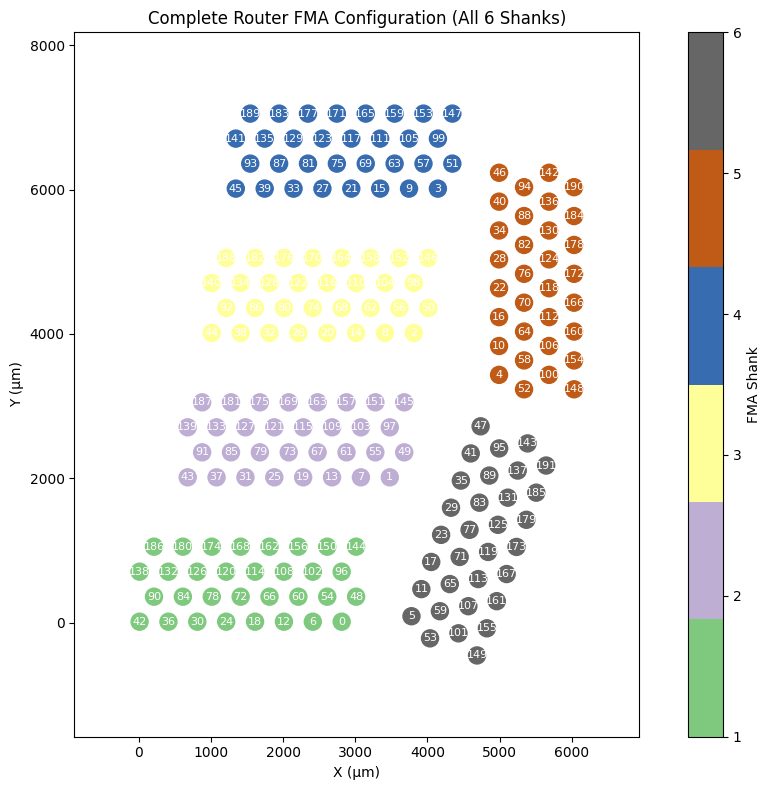

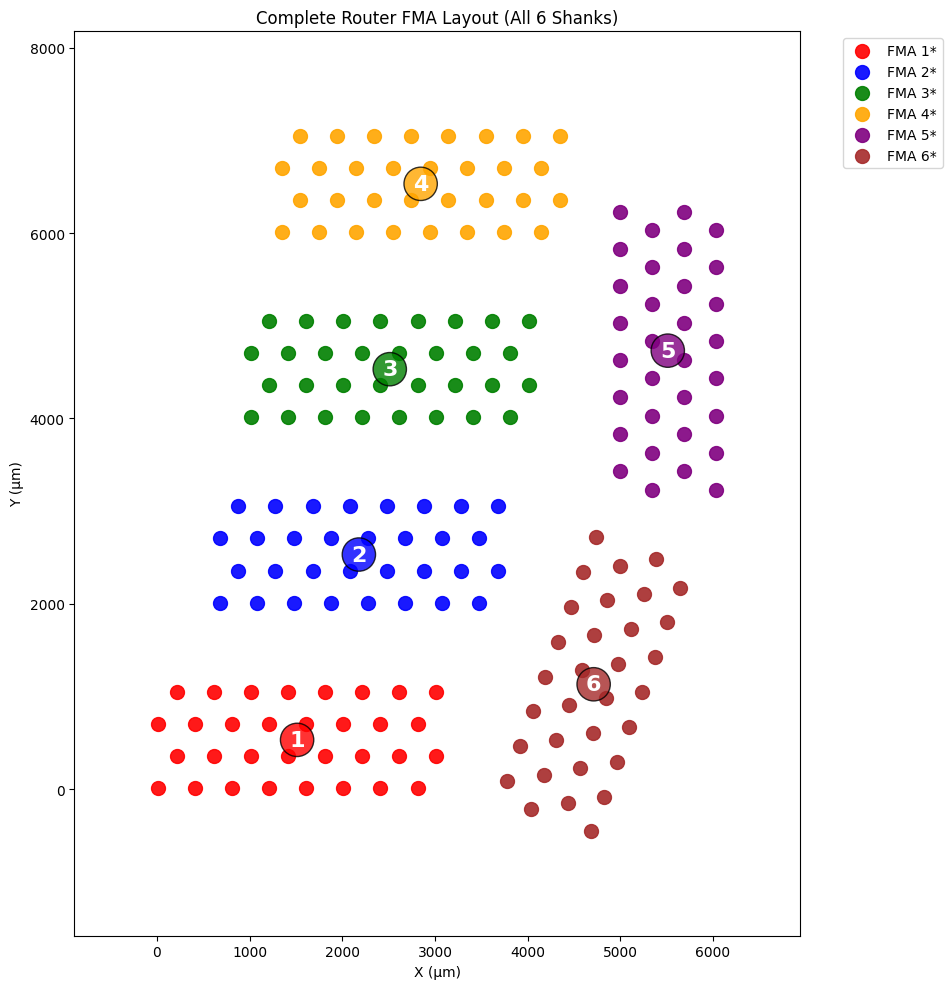

Probe configuration saved to router_channel_map_123456.json
Complete Router channel map saved as 'router_channel_map_123456.json'


In [10]:
# -- Full Router Implants Map --- 

def create_complete_router_configuration(config_name="router_123456"):
    """
    Create complete Router configuration using all 6 FMA arrays.
    
    Layout:
        4    5
       3
     2      6
    1
    """
    
    # Define all 6 possible positions for Router FMA arrays
    router_positions = {
        1: (0, 0),
        2: (DEFAULT_SHANK_H_SPACING/6., DEFAULT_SHANK_V_SPACING),
        3: (DEFAULT_SHANK_H_SPACING/4., 2 * DEFAULT_SHANK_V_SPACING),
        4: (DEFAULT_SHANK_H_SPACING/3., 3 * DEFAULT_SHANK_V_SPACING),
        5: (1.0 * DEFAULT_SHANK_H_SPACING, 2.1 * DEFAULT_SHANK_V_SPACING),
        6: (0.8 * DEFAULT_SHANK_H_SPACING, 0.3 * DEFAULT_SHANK_V_SPACING)
    }
    
    # Define transformations (shanks 5 and 6 need 90° rotation)
    router_transformations = {
        1: {},  # No transformation
        2: {},  # No transformation
        3: {},  # No transformation
        4: {},  # No transformation
        5: {'rotation_angle': np.pi/2, 'flip_x': True, 'flip_y': True},  # 90° rotation and flip
        6: {'rotation_angle': np.pi/2, 'additional_rotation': np.radians(-20), 'flip_x': True, 'flip_y': True}  # 90° + additional slant and flip
    }
    
    active_shanks = [1, 2, 3, 4, 5, 6]  # All 6 shanks
    
    # Create extended channel map pattern for 6 shanks (192 channels total)
    base_pattern_6_shanks = np.arange(0, 192, 6)
    extended_channel_map_pattern = np.concatenate([base_pattern_6_shanks + i for i in range(6)])
    
    return create_multichannel_probe(
        config_name=config_name,
        shank_positions=router_positions,
        active_shanks=active_shanks,
        channel_map_pattern=extended_channel_map_pattern,
        transformations=router_transformations,
        total_channels=192  # 6 shanks * 32 channels each
    ), router_positions, router_transformations

# Generate and save the complete Router configuration
print("=== Creating Complete Router Configuration (All 6 Shanks) ===")
complete_router_config, router_positions, router_transforms = create_complete_router_configuration()

# Visualize it
plot_probe_configuration(complete_router_config, "Complete Router FMA Configuration (All 6 Shanks)")
visualize_fma_layout(router_positions, [1, 2, 3, 4, 5, 6], router_transforms,
                    "Complete Router FMA Layout (All 6 Shanks)")

# Save the complete configuration
save_probe_configuration(complete_router_config, 'router_channel_map_123456.json')

print("Complete Router channel map saved as 'router_channel_map_123456.json'")
